In [0]:
!pip install tsundoku

In [0]:
!pip install sklearn torch tqdm nltk lazyme ansi requests gensim
!python -m nltk.downloader movie_reviews punkt

In [0]:
from IPython.display import display, Markdown, Latex
from tsundoku.word2vec_hints import *

# Overview


- <a href="#section-3-0">**3.0. Data Preparation**</a>
  - <a href="#section-3-0-1">3.0.1. *Vocabulary*</a>
    - <a href="#section-3-0-1-a"> Pet Peeve: using `gensim`</a>
  - <a href="#section-3-0-2">3.0.2. *Dataset*</a>  (<a href="#section-3-0-2-hints">Hints</a>)
    - <a href="#section-3-0-2-return-dict">Return `dict` in `__getitem__()`</a>
    - <a href="#section-3-0-2-labeleddata">Try `LabeledDataset`</a>
<br><br>
- <a href="#section-3-1">**3.1. Word2Vec from Scratch**</a>
  - <a href="#section-3-1-1">3.1.1. *CBOW*</a>
  - <a href="#section-3-1-2">3.1.2. *Skipgram*</a>
  - <a href="#section-3-1-3">3.1.3. *Word2Vec Dataset*</a> (<a href="#section-3-1-3-hint">Hints</a>)
  - <a href="#section-3-1-4-hint">3.1.4. *Train a CBOW model*</a>
    - <a href="#section-3-1-4-fill-cbow">The CBOW model</a>
    - <a href="#section-3-1-4-train-cbow">Train the model (*for real*)</a>
    - <a href="#section-3-1-4-evaluate-cbow">Evaluate the model</a>
    - <a href="#section-3-1-4-load-model">Load model at specific epoch</a>
  - <a href="#section-3-1-5">3.1.5. *Train a Skipgram model*</a>
    - <a href="#section-3-1-5-forward">Take a closer look at `forward()`</a>
    - <a href="#section-3-1-5-train">Train the model (*for real*)</a>
    - <a href="section-3-1-5-evaluate">Evaluate the model</a>
  - <a href="#section-3-1-6">3.1.6. *Loading Pre-trained Embeddings*</a>
    - <a href="#section-3-1-6-vocab">Override the Embedding vocabulary</a>
    - <a href="#section-3-1-6-pretrained">Override the Embedding weights</a>
    - <a href="#section-3-1-6-eval-skipgram">Evaluate on the Skipgram task</a>
    - <a href="#section-3-1-6-eval-cbow">Evaluate on the CBOW task</a>
    - <a href="#section-3-1-6-unfreeze-finetune">Unfreeeze and finetune</a>
    - <a href="#section-3-1-6-reval-cbow">Re-evaluate on the CBOW task</a>
<br><br>


<a id="section-3-0"></a>
# 3.0. Data Preparation

Before we train our own embeddings, lets first understand how to read text data into pytorch.
The native pytorch way to load datasets is to use the `torch.utils.data.Dataset` object.

There are already several other libraries that help with loading text datasets, e.g. 

 - FastAI https://docs.fast.ai/text.data.html
 - AllenNLP https://allenai.github.io/allennlp-docs/api/allennlp.data.dataset.html
 - Torch Text https://github.com/pytorch/text#data
 - Texar https://texar.readthedocs.io/en/latest/code/data.html#id4 
 - SpaCy https://github.com/explosion/thinc
 

But to truly understand and use it for the custom datasets you'll see at work, lets learn it the native way.

<a id="section-3-0-1"></a>
## 3.0.1  Vocabulary

Given a text, the first thing to do is to build a vocabulary (i.e. a dictionary of unique words) and assign an index to each unique word.

In [0]:
import random
from itertools import chain

from tqdm import tqdm
from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np

from functools import partial
from torch.utils.data import Dataset, DataLoader
from torch import functional as F


In [0]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize


In [0]:

text = """Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in corpora, 
the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a relation 
between two phenomena is demonstrably non-random, does not support the inference 
that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis testing 
has been used, and show how it has often led to unhelpful or misleading results.""".lower()

tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(text)]

uniq_tokens = set(chain(*tokenized_text))

vocab = {}   # Assign indices to every word.
idx2tok = {} # Also keep an dict of index to words.
for i, token in enumerate(uniq_tokens):
    vocab[token] = i
    idx2tok[i] = token

In [0]:
vocab

{'corpora': 0,
 'corpus': 1,
 '.': 2,
 'unhelpful': 3,
 'relation': 4,
 'it': 5,
 'never': 6,
 'the': 7,
 'not': 8,
 'used': 9,
 'and': 10,
 'hypothesis': 11,
 'support': 12,
 'linguistic': 13,
 'language': 14,
 'which': 15,
 'will': 16,
 'in': 17,
 'true': 18,
 'words': 19,
 'experimental': 20,
 'of': 21,
 'always': 22,
 'null': 23,
 'associations': 24,
 'or': 25,
 '(': 26,
 'able': 27,
 'been': 28,
 'show': 29,
 'how': 30,
 'choose': 31,
 'often': 32,
 'frequencies': 33,
 'misleading': 34,
 'do': 35,
 'has': 36,
 'led': 37,
 'non-random': 38,
 'randomness': 39,
 'data': 40,
 'does': 41,
 'where': 42,
 'inference': 43,
 'shall': 44,
 'demonstrably': 45,
 'that': 46,
 'there': 47,
 'users': 48,
 'establish': 49,
 'at': 50,
 'testing': 51,
 'two': 52,
 'studies': 53,
 'hence': 54,
 'literature': 55,
 'so': 56,
 'systematically': 57,
 ')': 58,
 'we': 59,
 ',': 60,
 'arbitrary': 61,
 'look': 62,
 'enough': 63,
 'essentially': 64,
 'uses': 65,
 'statistical': 66,
 'when': 67,
 'almost': 68

In [0]:
# Retrieve the index of the word 'corpora'
vocab['non-random']

38

In [0]:
# The indexed representation of the first sentence.

sent0 = tokenized_text[0]

[vocab[token] for token in sent0] 

[14, 48, 6, 31, 19, 79, 60, 10, 14, 83, 64, 38, 2]

<a id="section-3-0-1-a"></a>

### Pet Peeve (Gensim)

I (Liling) don't really like to write my own vectorizer the `gensim` has functions that are optimized for such operations. In fact, I've written a [whole preprocessing pipeline library for me to use for language modelling and machine translation purposes](https://github.com/alvations/komorebi/blob/master/komorebi/text.py) =)

Using `gensim`, I would have written the above as such:

In [0]:
from gensim.corpora.dictionary import Dictionary
vocab = Dictionary(tokenized_text)

In [0]:
# Note the key-value order is different of gensim from the native Python's
dict(vocab.items())

{0: ',',
 1: '.',
 2: 'and',
 3: 'choose',
 4: 'essentially',
 5: 'is',
 6: 'language',
 7: 'never',
 8: 'non-random',
 9: 'randomly',
 10: 'users',
 11: 'words',
 12: 'a',
 13: 'hypothesis',
 14: 'null',
 15: 'posits',
 16: 'randomness',
 17: 'statistical',
 18: 'testing',
 19: 'uses',
 20: 'which',
 21: 'at',
 22: 'be',
 23: 'corpora',
 24: 'hence',
 25: 'in',
 26: 'linguistic',
 27: 'look',
 28: 'phenomena',
 29: 'the',
 30: 'true',
 31: 'we',
 32: 'when',
 33: 'will',
 34: '(',
 35: ')',
 36: 'able',
 37: 'almost',
 38: 'always',
 39: 'data',
 40: 'enough',
 41: 'establish',
 42: 'it',
 43: 'moreover',
 44: 'not',
 45: 'shall',
 46: 'that',
 47: 'there',
 48: 'to',
 49: 'where',
 50: 'arbitrary',
 51: 'between',
 52: 'corpus',
 53: 'demonstrably',
 54: 'do',
 55: 'does',
 56: 'fact',
 57: 'frequently',
 58: 'have',
 59: 'inference',
 60: 'relation',
 61: 'so',
 62: 'studies',
 63: 'support',
 64: 'two',
 65: 'are',
 66: 'associations',
 67: 'evidence',
 68: 'experimental',
 69: 'fr

In [0]:
vocab.token2id['corpora']

23

In [0]:
vocab.doc2idx(sent0)

[6, 10, 7, 3, 11, 9, 0, 2, 6, 5, 4, 8, 1]

The "indexed form" of the tokens in the sentence forms the ***vectorized*** input to the `nn.Embedding` layer in PyTorch.

<a id="section-3-0-2"></a>

# 3.0.2 Dataset

Lets try creating a `torch.utils.data.Dataset` object.

In [0]:
from torch.utils.data import Dataset, DataLoader

class Text(Dataset):
    def __init__(self, tokenized_texts):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.vocab = Dictionary(tokenized_texts)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        # Hint: You want to return a vectorized sentence here.
        return {'x': self.???}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.???
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

<a id="section-3-0-2-hints"></a>
## Hints to the above cell

In [0]:
# Option 1: To see the hint and partial code for the cell above, uncomment the following line.
##hint_dataset_vectorize()
##code_text_dataset_vectorize()

# Option 2: "I give up just, run the code for me" 
# Uncomment the next two lines, if you really gave up... 
#full_code_text_dataset_vectorize()
#from tsundoku.word2vec import Text


In [0]:
tokenized_text[5]

['we',
 'present',
 'experimental',
 'evidence',
 'of',
 'how',
 'arbitrary',
 'associations',
 'between',
 'word',
 'frequencies',
 'and',
 'corpora',
 'are',
 'systematically',
 'non-random',
 '.']

In [0]:
text_dataset = Text(tokenized_text)

In [0]:
text_dataset[5] # First sentence.

{'x': [31, 72, 68, 67, 71, 70, 50, 66, 51, 74, 69, 2, 23, 65, 73, 8, 1]}

<a id="section-3-0-2-return-dict"></a>

### Return `dict` in `__getitem__()`

This is nice if we're just representing sentences/documents by their indices but when we're doing machine learning, we usually have `X` and `Y`. 

If we have labels for the each sentence, we can also put it into to `__getitem__()` by having it return a dictionary.

In [0]:
from torch.utils.data import Dataset, DataLoader

class LabeledText(Dataset):
    def __init__(self, tokenized_texts, labels):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self.labels = labels # Sentence level labels.
        self.vocab = Dictionary(self.sents)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        return {'x': self.vectorize(self.sents[index]), 'y': self.labels[index]}

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

<a id="section-3-0-2-labeleddata"></a>

### Lets try the `LabeledDataset` on a movie review corpus

In [0]:
from nltk.corpus import movie_reviews

In [0]:
documents = []
labels = []

for fileid in tqdm(movie_reviews.fileids()):
    label = fileid.split('/')[0]
    doc = word_tokenize(movie_reviews.open(fileid).read())
    documents.append(doc)
    labels.append(label)

100%|██████████| 2000/2000 [00:14<00:00, 139.99it/s]


In [0]:
print(documents[0])

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'s", 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '``', 'sorta', '``', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind-fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'bad', 'ways'

In [0]:
labeled_dataset = LabeledText(documents, labels)

In [0]:
print(labeled_dataset[0])  # First review in the data.

{'X': [243, 17, 314, 294, 77, 140, 307, 20, 68, 237, 6, 97, 34, 299, 98, 8, 302, 135, 167, 33, 22, 8, 226, 220, 297, 145, 87, 6, 60, 158, 136, 74, 307, 262, 157, 165, 153, 179, 6, 34, 149, 214, 8, 333, 2, 297, 82, 18, 326, 297, 204, 34, 19, 280, 19, 124, 230, 8, 8, 8, 79, 17, 20, 199, 204, 129, 297, 294, 133, 296, 311, 225, 20, 322, 75, 164, 6, 60, 245, 169, 165, 20, 322, 46, 234, 8, 337, 168, 333, 188, 304, 253, 33, 108, 148, 226, 307, 345, 6, 272, 163, 132, 37, 122, 337, 42, 307, 59, 297, 201, 6, 196, 341, 348, 152, 34, 290, 4, 185, 156, 1, 195, 5, 6, 60, 300, 38, 142, 34, 46, 328, 220, 189, 28, 315, 220, 122, 6, 34, 301, 128, 173, 86, 208, 276, 304, 226, 76, 8, 302, 263, 307, 150, 293, 304, 246, 209, 72, 6, 60, 113, 169, 295, 8, 277, 333, 38, 297, 248, 341, 297, 204, 18, 331, 6, 170, 186, 247, 168, 296, 169, 2, 271, 309, 172, 8, 169, 282, 221, 19, 216, 19, 60, 299, 95, 167, 304, 19, 116, 19, 342, 165, 337, 347, 6, 40, 33, 43, 194, 6, 150, 215, 164, 333, 2, 141, 225, 8, 300, 38, 96, 

In [0]:
print(labeled_dataset[0]['x'])  # First review in vectorized index format.

[243, 17, 314, 294, 77, 140, 307, 20, 68, 237, 6, 97, 34, 299, 98, 8, 302, 135, 167, 33, 22, 8, 226, 220, 297, 145, 87, 6, 60, 158, 136, 74, 307, 262, 157, 165, 153, 179, 6, 34, 149, 214, 8, 333, 2, 297, 82, 18, 326, 297, 204, 34, 19, 280, 19, 124, 230, 8, 8, 8, 79, 17, 20, 199, 204, 129, 297, 294, 133, 296, 311, 225, 20, 322, 75, 164, 6, 60, 245, 169, 165, 20, 322, 46, 234, 8, 337, 168, 333, 188, 304, 253, 33, 108, 148, 226, 307, 345, 6, 272, 163, 132, 37, 122, 337, 42, 307, 59, 297, 201, 6, 196, 341, 348, 152, 34, 290, 4, 185, 156, 1, 195, 5, 6, 60, 300, 38, 142, 34, 46, 328, 220, 189, 28, 315, 220, 122, 6, 34, 301, 128, 173, 86, 208, 276, 304, 226, 76, 8, 302, 263, 307, 150, 293, 304, 246, 209, 72, 6, 60, 113, 169, 295, 8, 277, 333, 38, 297, 248, 341, 297, 204, 18, 331, 6, 170, 186, 247, 168, 296, 169, 2, 271, 309, 172, 8, 169, 282, 221, 19, 216, 19, 60, 299, 95, 167, 304, 19, 116, 19, 342, 165, 337, 347, 6, 40, 33, 43, 194, 6, 150, 215, 164, 333, 2, 141, 225, 8, 300, 38, 96, 6, 300

In [0]:
print(labeled_dataset[0]['y'])  # Label of the first review in the data. 

neg


<a id="section-3-1"></a>

# 3.1 Word2Vec Training

Word2Vec has two training variants:

 - **Continuous Bag of Words (CBOW)**: Predict center word from (bag of) context words.
 - **Skip-grams**: Predict context words given center word.
  
Visually, they look like this:



<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-cbow.png" width="500" align="left">

Fig. 1. The skip-gram model. Both the input vector xx and the output yy are one-hot encoded word representations. <br>The hidden layer is the word embedding of size NN.



<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-skip-gram.png" width="500" align="left">

Fig. 2. The CBOW model. Word vectors of multiple context words are averaged to get a fixed-length vector as in the hidden layer. Other symbols have the same meanings as in Fig 1.

(Pretty network images above are from [https://lilianweng.github.io](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html#context-based-continuous-bag-of-words-cbow))

<a id="section-3-1-1"></a>

## 3.1.1. CBOW

CBOW windows through the sentence and picks out the center word as the `Y` and the surrounding context words as the inputs `X`. 


In [0]:
from lazyme import per_window, per_chunk

xx =[1,2,3,4]
list(per_window(xx, n=2))
list(per_chunk(xx, n=3))

[(1, 2, 3), (4, None, None)]

In [0]:
def per_window(sequence, n=1):
    """
    From http://stackoverflow.com/q/42220614/610569
        >>> list(per_window([1,2,3,4], n=2))
        [(1, 2), (2, 3), (3, 4)]
        >>> list(per_window([1,2,3,4], n=3))
        [(1, 2, 3), (2, 3, 4)]
    """
    start, stop = 0, n
    seq = list(sequence)
    while stop <= len(seq):
        yield seq[start:stop]
        start += 1
        stop += 1

def cbow_iterator(tokens, window_size):
    n = window_size * 2 + 1
    for window in per_window(tokens, n):
        target = window.pop(window_size)
        yield window, target   # X = window ; Y = target. 


In [0]:
sent0 = ['language', 'users', 'never', 'choose', 'words', 'randomly', ',', 
         'and', 'language', 'is', 'essentially', 'non-random', '.']

In [0]:
list(cbow_iterator(sent0, 2)) 

[(['language', 'users', 'choose', 'words'], 'never'),
 (['users', 'never', 'words', 'randomly'], 'choose'),
 (['never', 'choose', 'randomly', ','], 'words'),
 (['choose', 'words', ',', 'and'], 'randomly'),
 (['words', 'randomly', 'and', 'language'], ','),
 (['randomly', ',', 'language', 'is'], 'and'),
 ([',', 'and', 'is', 'essentially'], 'language'),
 (['and', 'language', 'essentially', 'non-random'], 'is'),
 (['language', 'is', 'non-random', '.'], 'essentially')]

In [0]:
list(cbow_iterator(sent0, 3)) 

[(['language', 'users', 'never', 'words', 'randomly', ','], 'choose'),
 (['users', 'never', 'choose', 'randomly', ',', 'and'], 'words'),
 (['never', 'choose', 'words', ',', 'and', 'language'], 'randomly'),
 (['choose', 'words', 'randomly', 'and', 'language', 'is'], ','),
 (['words', 'randomly', ',', 'language', 'is', 'essentially'], 'and'),
 (['randomly', ',', 'and', 'is', 'essentially', 'non-random'], 'language'),
 ([',', 'and', 'language', 'essentially', 'non-random', '.'], 'is')]

<a id="section-3-1-2"></a>

## 3.1.2. Skipgram

Skipgram training windows through the sentence and pictures out the center word as the input `X` and the context words as the outputs `Y`, additionally, it will randommly sample words not in the window as **negative samples**.

In [0]:
def skipgram_iterator(tokens, window_size):
    n = window_size * 2 + 1 
    for i, window in enumerate(per_window(tokens, n)):
        target = window.pop(window_size)
        # Generate positive samples.
        for context_word in window:
            yield target, context_word, 1
        # Generate negative samples.
        for _ in range(n-1):
            leftovers = tokens[:i] + tokens[i+n:]
            yield target, random.choice(leftovers), 0

In [0]:
list(skipgram_iterator(sent0, 2))

[('never', 'language', 1),
 ('never', 'users', 1),
 ('never', 'choose', 1),
 ('never', 'words', 1),
 ('never', '.', 0),
 ('never', 'non-random', 0),
 ('never', 'non-random', 0),
 ('never', 'language', 0),
 ('choose', 'users', 1),
 ('choose', 'never', 1),
 ('choose', 'words', 1),
 ('choose', 'randomly', 1),
 ('choose', '.', 0),
 ('choose', 'language', 0),
 ('choose', 'essentially', 0),
 ('choose', 'is', 0),
 ('words', 'never', 1),
 ('words', 'choose', 1),
 ('words', 'randomly', 1),
 ('words', ',', 1),
 ('words', 'language', 0),
 ('words', 'language', 0),
 ('words', 'is', 0),
 ('words', 'and', 0),
 ('randomly', 'choose', 1),
 ('randomly', 'words', 1),
 ('randomly', ',', 1),
 ('randomly', 'and', 1),
 ('randomly', 'never', 0),
 ('randomly', 'non-random', 0),
 ('randomly', 'is', 0),
 ('randomly', 'non-random', 0),
 (',', 'words', 1),
 (',', 'randomly', 1),
 (',', 'and', 1),
 (',', 'language', 1),
 (',', 'essentially', 0),
 (',', 'essentially', 0),
 (',', 'non-random', 0),
 (',', 'non-random

## Cut-away: What is `partial`?

The [`functools.partial`](https://docs.python.org/3.7/library/functools.html#functools.partial) function in Python is a mechanism to overload a function with preset arguments. 

For example:

In [0]:
from nltk import ngrams

# Generates bigrams
list(ngrams('this is a sentence'.split(), n=2))

[('this', 'is'), ('is', 'a'), ('a', 'sentence')]

In [0]:
from functools import partial

# You can create a new function that "preset" the `n` argument, e.g.
bigrams = partial(ngrams, n=2)
trigrams = partial(ngrams, n=3)

In [0]:
list(trigrams('this is a sentence'.split()))

[('this', 'is', 'a'), ('is', 'a', 'sentence')]

In [0]:
list(bigrams('this is a sentence'.split()))

[('this', 'is'), ('is', 'a'), ('a', 'sentence')]

<a id="section-3-1-3"></a>

## 3.1.3 Word2Vec Dataset

Now that we know what are the inputs `X` and outputs `Y` of the Word2Vec task. 

Lets put everything together and modify the `Dataset` so that `__getitem__` retrieves CBOW or Skipgram formats.

In [0]:

class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        self.vocab = Dictionary(self.sents)
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.

        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len

    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized.
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx
        return self.???(tokens)

    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

    def cbow_iterator(self, tokens, window_size):
        ???

    def skipgram_iterator(self, tokens, window_size):
        ???

<a id="section-3-1-3-hint"></a>
## Hints for the cell above.

In [0]:
# Option 1: To see the hint and partial code for the cell above, uncomment the following line.
##hint_word2vec_dataset()

# Option 2: "I give up just, run the code for me" 
# Uncomment the next two lines, if you really gave up... 
##full_code_word2vec_dataset()
##from tsundoku.word2vec import Word2VecText


<a id="section-3-1-4-hint"></a>

## 3.1.4. Train a CBOW model

### Lets Get Some Data

Lets take Kilgarriff (2005) , "Language is never ever, ever random". 

In [0]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

tokenized_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')

In [0]:
print(text[:1000])

                       Language is never, ever, ever, random

                                                               ADAM KILGARRIFF




Abstract
Language users never choose words randomly, and language is essentially
non-random. Statistical hypothesis testing uses a null hypothesis, which
posits randomness. Hence, when we look at linguistic phenomena in cor-
pora, the null hypothesis will never be true. Moreover, where there is enough
data, we shall (almost) always be able to establish that it is not true. In
corpus studies, we frequently do have enough data, so the fact that a rela-
tion between two phenomena is demonstrably non-random, does not sup-
port the inference that it is not arbitrary. We present experimental evidence
of how arbitrary associations between word frequencies and corpora are
systematically non-random. We review literature in which hypothesis test-
ing has been used, and show how it has often led to unhelpful or mislead-
ing results.
Keywords: 쎲쎲쎲

1. Int

In [0]:
# Sanity check, lets take a look at the data.
print(tokenized_text[0])

['language', 'is', 'never', ',', 'ever', ',', 'ever', ',', 'random', 'adam', 'kilgarriff', 'abstract', 'language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.']


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
from lazyme import color_str

def visualize_predictions(x, y, prediction, vocab, window_size, unk='<unk>'):
    left = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[:window_size]])
    right = ' '.join([vocab.get(int(_x), '<unk>') for _x in x[window_size:]])
    target = vocab.get(int(y), '<unk>')

    if not prediction:
        predicted_word = '______'
    else:
        predicted_word = vocab.get(int(prediction), '<unk>') 
    print(color_str(target, 'green'), '\t' if len(target) > 6 else '\t\t', 
          left, color_str(predicted_word, 'green' if target == predicted_word else 'red'), right)
    

sent_idx = 10
window_size = 2
w2v_dataset = Word2VecText(tokenized_text, window_size=window_size, variant='cbow')
print(' '.join(w2v_dataset.sents[sent_idx]))
for w2v_io in w2v_dataset[sent_idx]:
    context, target = w2v_io['x'], w2v_io['y']
    context, target = tensor(context).to(device), tensor(target).to(device)
    visualize_predictions(context, target, None, w2v_dataset.vocab, window_size)

the bulk of linguistic questions concern the dis- tinction between a and m. a linguistic account of a phenomenon gen- erally gives us reason to view the relation between , for example , a verb ’ s syntax and its semantics , as motivated rather than arbitrary .
of 		 the bulk ______ linguistic questions
linguistic 	 bulk of ______ questions concern
questions 	 of linguistic ______ concern the
concern 	 linguistic questions ______ the dis-
the 		 questions concern ______ dis- tinction
dis- 		 concern the ______ tinction between
tinction 	 the dis- ______ between a
between 	 dis- tinction ______ a and
a 		 tinction between ______ and m.
and 		 between a ______ m. a
m. 		 a and ______ a linguistic
a 		 and m. ______ linguistic account
linguistic 	 m. a ______ account of
account 	 a linguistic ______ of a
of 		 linguistic account ______ a phenomenon
a 		 account of ______ phenomenon gen-
phenomenon 	 of a ______ gen- erally
gen- 		 a phenomenon ______ erally gives
erally 		 phenomenon gen- 

<a id="section-3-1-4-cbow-model"></a>

## The CBOW Model

<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-cbow.png" width="500" align="left">


(Image from https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html)

In [0]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


## Lets take a closer look from the inputs to the first `nn.Linear`

Cos after it reach the first `nn.Linear` it's just the same as our multi-layered perceptron example =)

In [0]:
w2v_dataset[0]

[{'x': [10, 8, 0, 7], 'y': 11},
 {'x': [8, 11, 7, 0], 'y': 0},
 {'x': [11, 0, 0, 7], 'y': 7},
 {'x': [0, 7, 7, 0], 'y': 0},
 {'x': [7, 0, 0, 13], 'y': 7},
 {'x': [0, 7, 13, 3], 'y': 0},
 {'x': [7, 0, 3, 9], 'y': 13},
 {'x': [0, 13, 9, 2], 'y': 3},
 {'x': [13, 3, 2, 10], 'y': 9},
 {'x': [3, 9, 10, 15], 'y': 2},
 {'x': [9, 2, 15, 11], 'y': 10},
 {'x': [2, 10, 11, 5], 'y': 15},
 {'x': [10, 15, 5, 16], 'y': 11},
 {'x': [15, 11, 16, 14], 'y': 5},
 {'x': [11, 5, 14, 0], 'y': 16},
 {'x': [5, 16, 0, 4], 'y': 14},
 {'x': [16, 14, 4, 10], 'y': 0},
 {'x': [14, 0, 10, 8], 'y': 4},
 {'x': [0, 4, 8, 6], 'y': 10},
 {'x': [4, 10, 6, 12], 'y': 8},
 {'x': [10, 8, 12, 1], 'y': 6}]

In [0]:
# Lets take a look at the first output.


x, y = w2v_dataset[0][0]['x'],  w2v_dataset[0][0]['y']

x = tensor(x)
y = autograd.Variable(tensor(y, dtype=torch.long))
print(x)
print(y)

tensor([10,  8,  0,  7])
tensor(11)


In [0]:
embd_size = 5
emb = nn.Embedding(len(w2v_dataset.vocab), embd_size)
emb.state_dict()

OrderedDict([('weight', tensor([[-0.5309, -0.2498,  0.4560,  1.2961, -0.4387],
                      [ 0.3382, -0.0703,  0.3431,  0.1622,  0.9764],
                      [ 1.0735, -0.5736, -1.2363, -1.4552,  0.9341],
                      ...,
                      [ 1.8404, -2.1452,  1.7231,  1.5320,  0.3120],
                      [-0.1742,  0.4641,  0.4268, -0.5084, -0.8903],
                      [-0.2273, -0.4780,  0.2075, -1.3358,  0.0986]]))])

In [0]:
print(emb.state_dict()['weight'].shape)
emb.state_dict()['weight']

torch.Size([1388, 5])


tensor([[-0.5309, -0.2498,  0.4560,  1.2961, -0.4387],
        [ 0.3382, -0.0703,  0.3431,  0.1622,  0.9764],
        [ 1.0735, -0.5736, -1.2363, -1.4552,  0.9341],
        ...,
        [ 1.8404, -2.1452,  1.7231,  1.5320,  0.3120],
        [-0.1742,  0.4641,  0.4268, -0.5084, -0.8903],
        [-0.2273, -0.4780,  0.2075, -1.3358,  0.0986]])

In [0]:
print(emb(x).shape)
print(emb(x))

torch.Size([5, 5])
tensor([[-0.8014, -2.1698,  0.7498, -0.7403,  1.1497],
        [ 0.2756,  0.0506, -0.7995, -0.1418,  1.0545],
        [ 0.2757, -0.2900, -0.3487,  1.7644,  1.2935],
        [-0.8583,  0.8299,  0.3863, -1.6557,  1.5273],
        [ 0.8718, -0.5214,  0.2409,  2.1781,  0.0841]],
       grad_fn=<EmbeddingBackward>)


In [0]:
print(emb(x).view(1, -1).shape)
emb(x).view(1, -1)

torch.Size([1, 25])


tensor([[-0.8014, -2.1698,  0.7498, -0.7403,  1.1497,  0.2756,  0.0506, -0.7995,
         -0.1418,  1.0545,  0.2757, -0.2900, -0.3487,  1.7644,  1.2935, -0.8583,
          0.8299,  0.3863, -1.6557,  1.5273,  0.8718, -0.5214,  0.2409,  2.1781,
          0.0841]], grad_fn=<ViewBackward>)

In [0]:
hidden_size = 100
lin1 = nn.Linear(len(x)*embd_size, hidden_size)
print(lin1.state_dict())

OrderedDict([('weight', tensor([[-0.1447, -0.1136, -0.0130,  ...,  0.0218, -0.1538, -0.1554],
        [ 0.0928, -0.0122, -0.0744,  ...,  0.1641, -0.1238,  0.1497],
        [ 0.0631,  0.1008, -0.1635,  ..., -0.0189, -0.0931,  0.1022],
        ...,
        [ 0.0705, -0.1190,  0.0672,  ..., -0.0613, -0.0673, -0.0518],
        [ 0.1590,  0.0873, -0.1814,  ...,  0.0404,  0.1916,  0.1826],
        [-0.1386,  0.0480,  0.1366,  ...,  0.1606, -0.1528, -0.1577]])), ('bias', tensor([-6.5666e-02, -1.6835e-02, -1.5871e-01, -1.7670e-01, -1.7749e-01,
        -1.5189e-01, -7.8464e-04,  5.8088e-02,  1.4027e-01, -2.4234e-03,
         1.2355e-01, -3.1391e-02,  5.7199e-02, -4.8530e-02,  4.8086e-02,
         8.2727e-02, -5.1193e-02,  8.2017e-02, -1.0416e-01, -1.4997e-01,
        -1.6799e-01,  1.6884e-01,  1.4976e-01,  1.7572e-01,  7.7179e-02,
        -5.0694e-05,  1.7845e-01, -1.9768e-01,  1.7715e-01, -1.6373e-01,
        -1.5114e-01, -1.9456e-01,  3.0764e-02,  7.8759e-02,  1.5015e-01,
        -9.7355e-02,

In [0]:
print(lin1.state_dict()['weight'].shape)
print(lin1.state_dict()['weight'])

torch.Size([100, 25])
tensor([[-0.1447, -0.1136, -0.0130,  ...,  0.0218, -0.1538, -0.1554],
        [ 0.0928, -0.0122, -0.0744,  ...,  0.1641, -0.1238,  0.1497],
        [ 0.0631,  0.1008, -0.1635,  ..., -0.0189, -0.0931,  0.1022],
        ...,
        [ 0.0705, -0.1190,  0.0672,  ..., -0.0613, -0.0673, -0.0518],
        [ 0.1590,  0.0873, -0.1814,  ...,  0.0404,  0.1916,  0.1826],
        [-0.1386,  0.0480,  0.1366,  ...,  0.1606, -0.1528, -0.1577]])


In [0]:
print(lin1(emb(x).view(1, -1)).shape)
lin1(emb(x).view(1, -1))

torch.Size([1, 100])


tensor([[-1.2671e+00, -1.0560e+00, -2.7547e-01, -3.9239e-01,  1.0550e+00,
          5.8454e-02,  2.7364e-01, -2.1694e-01, -4.2596e-01, -3.0849e-02,
         -3.5111e-01, -6.6442e-01,  4.4285e-01, -1.4273e+00, -1.0141e-01,
          8.4337e-01, -8.1876e-01, -5.3560e-01, -9.8946e-01, -2.4821e-01,
          4.9500e-01,  2.4280e-01, -1.3943e+00, -8.1615e-02, -9.4806e-03,
         -6.5384e-01, -2.9202e-01, -2.0307e-01,  3.1281e-02, -1.1027e+00,
          6.8971e-01,  9.4438e-01,  2.0563e-01,  4.3321e-01,  1.1221e-01,
         -1.1211e-01,  5.7779e-01, -1.8758e-01, -6.2340e-01, -8.7328e-02,
         -1.1230e+00,  7.8058e-01,  7.0934e-01, -6.2332e-01,  2.4691e-01,
          2.1622e-03,  5.3593e-01,  2.7730e-01, -2.6210e-01, -2.6775e-01,
          1.9049e-01,  1.1417e+00,  5.3801e-01,  1.1117e+00, -1.4210e-01,
          4.8679e-02,  4.3074e-01, -3.6613e-01,  2.2502e-01, -6.7378e-01,
         -1.4379e+00, -2.8330e-01, -7.2398e-01,  4.0467e-01,  6.0282e-02,
          5.6468e-01,  5.9446e-01, -4.

In [0]:
relu = nn.ReLU()
print(relu(lin1(emb(x).view(1, -1))).shape)
relu(lin1(emb(x).view(1, -1)))

torch.Size([1, 100])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0550, 0.0585, 0.2736, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.4429, 0.0000, 0.0000, 0.8434, 0.0000, 0.0000,
         0.0000, 0.0000, 0.4950, 0.2428, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0313, 0.0000, 0.6897, 0.9444, 0.2056, 0.4332, 0.1122, 0.0000,
         0.5778, 0.0000, 0.0000, 0.0000, 0.0000, 0.7806, 0.7093, 0.0000, 0.2469,
         0.0022, 0.5359, 0.2773, 0.0000, 0.0000, 0.1905, 1.1417, 0.5380, 1.1117,
         0.0000, 0.0487, 0.4307, 0.0000, 0.2250, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4047, 0.0603, 0.5647, 0.5945, 0.0000, 0.0000, 0.3658, 0.0000, 0.0000,
         0.0000, 0.8864, 0.7821, 0.1837, 0.0000, 0.5602, 0.3517, 0.0897, 0.5124,
         0.8173, 0.9934, 0.0000, 0.0000, 0.7138, 0.1639, 0.0578, 0.0000, 0.0000,
         0.6538, 0.0458, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3923, 0.6445,
         0.0000]], grad_fn=<ThresholdBackward0>)

In [0]:
lin2 = nn.Linear(hidden_size, len(w2v_dataset.vocab))
print(lin2.state_dict()['weight'].shape)
lin2.state_dict()['weight']

torch.Size([1388, 100])


tensor([[ 0.0725, -0.0418, -0.0470,  ...,  0.0875,  0.0200, -0.0492],
        [-0.0359, -0.0547,  0.0733,  ..., -0.0528,  0.0927, -0.0141],
        [-0.0723,  0.0796,  0.0544,  ...,  0.0629,  0.0833, -0.0260],
        ...,
        [ 0.0161, -0.0200, -0.0464,  ...,  0.0278,  0.0099, -0.0537],
        [ 0.0719, -0.0236, -0.0734,  ..., -0.0269,  0.0578, -0.0877],
        [-0.0688,  0.0176, -0.0377,  ...,  0.0769,  0.0392, -0.0416]])

In [0]:
h_x = relu(lin1(emb(x).view(1, -1)))
print(lin2(h_x).shape)
lin2(h_x)

torch.Size([1, 1388])


tensor([[-0.4737,  0.2024, -0.0957,  ...,  0.3202, -0.3416,  0.1011]],
       grad_fn=<AddmmBackward>)

In [0]:
softmax = nn.LogSoftmax(dim=1)
softmax(lin2(h_x)).detach().numpy().tolist()

[[-7.729094505310059,
  -7.0529561042785645,
  -7.351128578186035,
  -6.980468273162842,
  -7.116093635559082,
  -7.565708160400391,
  -7.476498126983643,
  -7.222686290740967,
  -7.558962821960449,
  -7.518165111541748,
  -7.190613269805908,
  -7.156388759613037,
  -6.849654197692871,
  -7.481348037719727,
  -7.07505989074707,
  -6.886816501617432,
  -7.235705375671387,
  -7.411858081817627,
  -7.311549663543701,
  -7.299731254577637,
  -7.217769622802734,
  -7.277176856994629,
  -7.421562194824219,
  -6.878456115722656,
  -7.575339317321777,
  -7.339748859405518,
  -7.422872543334961,
  -7.513821125030518,
  -7.49839448928833,
  -7.398869037628174,
  -7.750196933746338,
  -7.4314680099487305,
  -7.4705376625061035,
  -7.6934428215026855,
  -7.543959140777588,
  -7.3512349128723145,
  -7.210240840911865,
  -7.472490310668945,
  -7.07129430770874,
  -7.252291202545166,
  -7.235233306884766,
  -6.866705894470215,
  -7.021296501159668,
  -7.569563865661621,
  -7.426265239715576,
  -7.387

In [0]:
# Select the index with highest softmax probabilities
# See https://pytorch.org/docs/stable/torch.html#torch.max
torch.max(softmax(lin2(h_x)), 1)

(tensor([-6.5388], grad_fn=<MaxBackward0>), tensor([1136]))

<a id="section-3-1-4-train-cbow"></a>

# Now, we train the CBOW model for real.

In [0]:
# First we split the data into training and testing.
from sklearn.model_selection import train_test_split

tokenized_text_train, tokenized_text_test = train_test_split(tokenized_text, test_size=0.1, random_state=42)
len(tokenized_text_train), len(tokenized_text_test)

(211, 24)

In [0]:
### Hint: Click here to go back up to see the CBOW model

In [0]:
import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        # Put the input context indices into the embeddings
        # then squeeze it into a single dimension vector with tensor.view((1,-1))
        embedded = self.???(inputs).view((1, -1))
        # Put the embedding input through linear layer,
        # then an activation function to create the hidden layer.
        hid = F.relu(self.???(embedded))
        # Put the hidden layer through a second linear layer,
        out = self.???(hid)
        # then a last layer activation function to generate
        # pobabilities, hint https://pytorch.org/docs/stable/nn.html#torch.nn.functional.log_softmax
        log_probs = F.???(out, dim=1)
        return log_probs


In [0]:
embd_size = 100
learning_rate = 0.003
hidden_size = 100
window_size = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.NLLLoss()
# Hint: the CBOW model object you've created.
model = ???(vocab_size, embd_size, window_size, hidden_size).to(device)
optimizer = optim.???(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Zero gradient.
            optimizer.zero_grad()
            # Retrieve the inputs and outputs.
            x, y = w2v_io['x'], w2v_io['y']
            x = tensor(x).to(device)
            y = autograd.Variable(tensor(y, dtype=torch.long)).to(device)
            # Calculate the log probability of the context embeddings.
            logprobs = ???(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = ???(logprobs, y.unsqueeze(0)) 
            loss.???()
            optimizer.???()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))




  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-17:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  2%|▏         | 2/100 [00:13<11:19,  6.94s/it]


KeyboardInterrupt: 

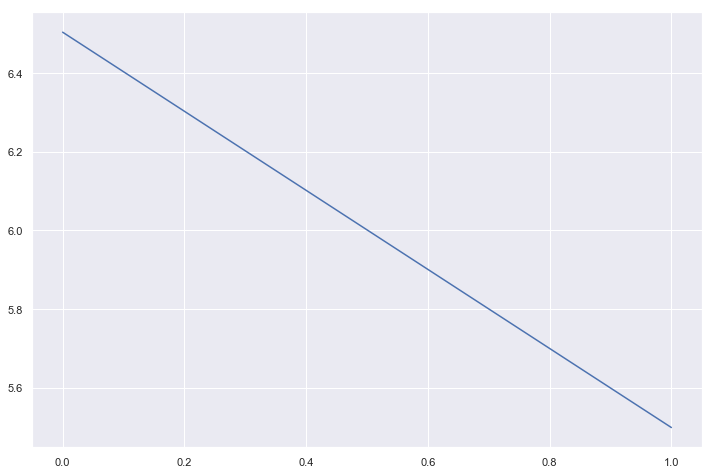

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

plt.plot(losses)
plt.show()

<a id="section-3-1-4-evaluate-cbow"></a>

# Apply and Evaluate the CBOW Model 

In [0]:
from lazyme import color_str

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x']).to(device)
        y = tensor(w2v_io['y']).to(device)
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            # Remember how to get the best prediction output? 
            # Hint: https://pytorch.org/docs/stable/torch.html#torch.max
            _, prediction =  torch.???(model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem is essentially this
essentially 	 problem is the this :
this 		 is essentially the : if
: 		 essentially this ______ if a
if 		 this : for a word
a 		 : if and word (
word 		 if a ( ( or
( 		 a word ______ or bigram
or 		 word ( and bigram ,
bigram 		 ( or ) , or
<unk> 		 , or is , or
<unk> 		 , or and etc .
is 		 the web of a vast
a 		 web is not vast re-
vast 		 is a the re- source
re- 		 a vast of source for
source 		 vast re- ______ for many
the 		 is that the association is
association 	 that the ______ is random
is 		 the association is random ,
random 		 association is the , arbitrary
, 		 is random ______ arbitrary ,
arbitrary 	 random , and , motivated
, 		 , arbitrary ______ motivated or
motivated 	 arbitrary , and or pre-
<unk> 		 or pre- ) ( r
, 		 ( r ) a ,
<unk> 		 a , ever , p
their 		 however , and methods are
example 	 , for the , from
, 		 for example ______ from just
from 		 example , and just those
<unk> 		 just those the errors that
they 		 , and 

verb 		 , a ______ ’ s
’ 		 a verb of s syntax
s 		 verb ’ ______ syntax and
syntax 		 ’ s ______ and its
<unk> 		 and its the , as
motivated 	 , as is rather than
rather 		 as motivated and than arbitrary
than 		 motivated rather ______ arbitrary .
value 		 the average to of the
of 		 average value of the error
the 		 value of the error term
error 		 of the and term ,
term 		 the error of , language
, 		 error term is language is
language 	 term , and is never
is 		 , language is never ,
never 		 language is not , ever
, 		 is never ______ ever ,
ever 		 never , ever , ever
, 		 , ever ______ ever ,
ever 		 ever , ever , random
<unk> 		 ) 2 and is then
<unk> 		 is then of the hypothesis
<unk> 		 can , ever , be
<unk> 		 , be is as :
are 		 as : for the error
the 		 : are the error terms
error 		 are the two terms systematically
terms 		 the error hypothesis systematically greater
systematically 	 error terms is greater than
greater 	 terms systematically ______ than 0.5
than 		 system

In [0]:
torch.max(model(x), 1)
#model(x)

(tensor([-2.3261], grad_fn=<MaxBackward0>), tensor([4]))

In [0]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.1829787234042553


<a id="section-3-1-4-load-model"></a>

# Go back to the 5th Epoch

In [0]:
model_5 = CBOW(vocab_size, embd_size, window_size, hidden_size)
model_5 = torch.nn.DataParallel(model_5)
model_5.load_state_dict(torch.load('cbow_checkpoint_5.pt'))
model_5.eval()

DataParallel(
  (module): CBOW(
    (embeddings): Embedding(1303, 100)
    (linear1): Linear(in_features=400, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=1303, bias=True)
  )
)

In [0]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x']).to(device)
        y = tensor(w2v_io['y']).to(device)
        
        if -1 in x: # Skip unknown words.
            continue
            
        with torch.no_grad():
            _, prediction =  torch.max(model_5(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

is 		 the problem ______ essentially this
essentially 	 problem is the this :
this 		 is essentially to : if
: 		 essentially this ______ if a
if 		 this : of a word
a 		 : if as word (
word 		 if a to ( or
( 		 a word ______ or bigram
or 		 word ( as bigram ,
bigram 		 ( or ) , or
<unk> 		 , or random , or
<unk> 		 , or by etc .
is 		 the web is a vast
a 		 web is in vast re-
vast 		 is a to re- source
re- 		 a vast of source for
source 		 vast re- ______ for many
the 		 is that the association is
association 	 that the sample is random
is 		 the association ______ random ,
random 		 association is data , arbitrary
, 		 is random ______ arbitrary ,
arbitrary 	 random , random , motivated
, 		 , arbitrary ______ motivated or
motivated 	 arbitrary , and or pre-
<unk> 		 or pre- p ( r
, 		 ( r is a ,
<unk> 		 a , random , p
their 		 however , and methods are
example 	 , for random , from
, 		 for example of from just
from 		 example , and just those
<unk> 		 just those the errors that
th

<unk> 		 can , random , be
<unk> 		 , be is as :
are 		 as : of the error
the 		 : are or error terms
error 		 are the same terms systematically
terms 		 the error term systematically greater
systematically 	 error terms to greater than
greater 	 terms systematically to than 0.5
than 		 systematically greater the 0.5 ?
1 		 with just the % of
% 		 just 1 all of them
of 		 1 % and them ,
them 		 % of the , devastate
<unk> 		 , devastate ______ one of
the 		 one of the verbs for
verbs 		 of the null for which
for 		 the verbs ______ which we
which 		 verbs for the we have
<unk> 		 we have number of data
<unk> 		 , and and thresholding methods
will 		 thresholding methods ______ distinguish associated
distinguish 	 methods will ______ associated scfs
associated 	 will distinguish random scfs from
scfs 		 distinguish associated with from noise
from 		 associated scfs ______ noise .


In [0]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.22127659574468084


In [0]:
model(x).shape[1] == len(w2v_dataset.vocab)

True

# [optional] How to Handle Unknown Words? 

This is not the best way to handle unknown words, but we can simply assign an index for unknown words.

**Hint:** Ensure that you have `gensim` version >= 3.7.0 first. Otherwise this part of the code won't work. 

Try in your Python environment installation:

```
python -m pip install -U pip
python -m pip install -U gensim>=3.7.0
```

Or within the jupyter notebook:

In [0]:
!python -m pip install -U pip
!python -m pip install -U gensim>=3.7.0

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Requirement already up-to-date: pip in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (19.0.2)
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


To check version of `gensim` after installation:

In [0]:
import gensim
gensim.__version__

'3.7.0'

In [0]:
vocab = Dictionary(['this is a foo bar sentence'.split()])
dict(vocab.items())

{0: 'a', 1: 'bar', 2: 'foo', 3: 'is', 4: 'sentence', 5: 'this'}

In [0]:
# See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.patch_with_special_tokens
vocab = Dictionary(['this is a foo bar sentence'.split()])

try:
    special_tokens = {'<pad>': 0, '<unk>': 1}
    vocab.patch_with_special_tokens(special_tokens)
except: # If gensim is not 3.7.0
    pass
    
dict(vocab.items())

{6: 'a',
 7: 'bar',
 2: 'foo',
 3: 'is',
 4: 'sentence',
 5: 'this',
 0: '<pad>',
 1: '<unk>'}

# [optional] Lets Rewrite the `Word2VecText` Object

Now with the (i) unknown word patch in the vocabulary as well as (ii) `skipgram_iterator`

In [0]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Add the unknown word patch here.
        self.vocab = Dictionary(self.sents)
        try:
            special_tokens = {'<pad>': 0, '<unk>': 1}
            self.vocab.patch_with_special_tokens(special_tokens)
        except:
            pass
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

<a id="section-3-1-5"></a>

# Lets try the skipgram task

In [0]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_context = self.embeddings(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        score = torch.mm(embed_focus, torch.t(embed_context))
        log_probs = F.logsigmoid(score)
        return log_probs

<a id="section-3-1-5-foward"></a>

# Take a closer look at what's in the `forward()`

In [0]:
xx1 = torch.rand(1,20)
xx2 = torch.rand(1,20)

xx1_numpy = xx1.detach().numpy()
xx2_numpy = xx2.detach().numpy()

In [0]:
print(xx1_numpy.shape)
print(xx2_numpy.T.shape)
print(np.dot(xx1_numpy, xx2_numpy.T))

(1, 20)
(20, 1)
[[5.7234097]]


In [0]:
print(xx1.shape)
print(torch.t(xx2).shape) 

print(torch.mm(xx1, torch.t(xx2))) # 

torch.Size([1, 20])
torch.Size([20, 1])
tensor([[5.7234]])


<a id="section-3-1-5-train"></a>

# Train a Skipgram model (for real)

In [0]:
embd_size = 100
learning_rate = 0.03
hidden_size = 300
window_size = 3

# Initialize the dataset.
w2v_dataset = Word2VecText(tokenized_text_train, window_size=3, variant='skipgram')
vocab_size = len(w2v_dataset.vocab)

criterion = nn.MSELoss()
# Use the Skipgram object
model = ???(vocab_size, embd_size,).to(device)
optimizer = optim.???(model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epcoh_loss = 0
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x1, x2 = w2v_io['x']
            x1, x2 = tensor(x1).to(device), tensor(x2).to(device)
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.float)).to(device)
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = ???(x1, x2)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = ???(logprobs, y.unsqueeze(0)) 
            loss.???()
            optimizer.???()
            epcoh_loss += float(loss)
    torch.save(model.state_dict(), 'skipgram_checkpoint_{}.pt'.format(_e))
    losses.append(epcoh_loss)



  1%|          | 1/100 [00:41<1:08:04, 41.26s/it]

KeyboardInterrupt: 

<a id="section-3-1-5-evaluate"></a>

# Evaluate the model on the skipgram task

In [0]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        x1, x2 = tensor(x1), tensor(x2)
        y = w2v_io['y']
        _, prediction =  torch.max(model(x1, x2), 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [0]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.5


## Download the Collobert and Weston SENNA Embeddings


If you're on a Mac or Linux, you can use the `!` bang commands in the next cell to get the data.

```
!pip install kaggle
!mkdir -p .kaggle
!echo '{"username":"natgillin","key":"54ae95ab760b52c3307ed4645c6c9b5d"}' > .kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json
!kaggle datasets download -d alvations/vegetables-senna-embeddings --force -p ./
```

If you're on windows go to https://www.kaggle.com/alvations/vegetables-senna-embeddings and download the data files. 

What's most important are the 
 - `.txt` file that contains the vocabulary list
 - `.npy` file that contains the binarized numpy array
 
The rows of the numpy array corresponds to the vocabulary in the order from the `.txt` file.

<a id="section-3-1-6-vocab"></a>


## 3.1.6. Loading Pre-trained Embeddings

Lets overwrite the `Word2VecText` object with the pretrained embeddings. 

Most important thing is the overwrite the `Dictionary` from `gensim` with the vocabulary of the pre-trained embeddings, as such:

```python
        # Loads the pretrained keys. 
        with open('senna.wiki-reuters.lm2.50d.txt') as fin:
            pretrained_keys = {line.strip():i for i, line in enumerate(fin)}
        self.vocab = Dictionary({})
        self.vocab.token2id = pretrained_keys
```


In [0]:
class Word2VecText(Dataset):
    def __init__(self, tokenized_texts, window_size, variant):
        """
        :param tokenized_texts: Tokenized text.
        :type tokenized_texts: list(list(str))
        """
        self.sents = tokenized_texts
        self._len = len(self.sents)
        
        # Loads the pretrained keys. 
        with open('senna.wiki-reuters.lm2.50d.txt') as fin:
            pretrained_keys = {line.strip():i for i, line in enumerate(fin)}
        self.vocab = Dictionary({})
        self.vocab.token2id = pretrained_keys
        
        self.window_size = window_size
        self.variant = variant
        if variant.lower() == 'cbow':
            self._iterator = partial(self.cbow_iterator, window_size=self.window_size)
        elif variant.lower() == 'skipgram':
            self._iterator = partial(self.skipgram_iterator, window_size=self.window_size)

    def __getitem__(self, index):
        """
        The primary entry point for PyTorch datasets.
        This is were you access the specific data row you want.
        
        :param index: Index to the data point.
        :type index: int
        """
        vectorized_sent = self.vectorize(self.sents[index])
        
        return list(self._iterator(vectorized_sent))

    def __len__(self):
        return self._len
    
    def vectorize(self, tokens):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        return self.vocab.doc2idx(tokens, unknown_word_index=-1)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]
    
    def cbow_iterator(self, tokens, window_size):
        n = window_size * 2 + 1
        for window in per_window(tokens, n):
            target = window.pop(window_size)
            yield {'x': window, 'y': target}   # X = window ; Y = target. 
            
    def skipgram_iterator(self, tokens, window_size):
        n = window_size * 2 + 1 
        for i, window in enumerate(per_window(tokens, n)):
            focus = window.pop(window_size)
            # Generate positive samples.
            for context_word in window:
                yield {'x': (focus, context_word), 'y':1}
            # Generate negative samples.
            for _ in range(n-1):
                leftovers = tokens[:i] + tokens[i+n:]
                if leftovers:
                    yield {'x': (focus, random.choice(leftovers)), 'y':0}
                

<a id="section-3-1-6-pretrained"></a>

## Override the embeddings layer with the pre-trained weights.

In PyTorch, the weights of the `nn.Embedding` object can be easily overwritten with `from_pretrained` function, see https://pytorch.org/docs/stable/nn.html#embedding

In [0]:
class SkipGram(nn.Module):
    def __init__(self, pretrained_npy):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy)
    
    def forward(self, focus, context):
        # Put the index of the focus word into the embedding layer.
        embed_focus = self.???(focus).view((1, -1))
        # Put the index of the context word into the embedding layer.
        embed_context = self.???(context).view((1, -1))
        # See https://pytorch.org/docs/stable/torch.html#torch.t
        # Do a matrix multiplication between the focus and context embedding
        score = ???(embed_focus, torch.t(embed_context))
        # Then put it through a log sigmoid activation function
        # so that the output is between (log(0), log(1))
        log_probs = F.???(score)
        return log_probs

In [0]:
np.load('senna.wiki-reuters.lm2.50d.npy')

array([[-1.03682 ,  1.77856 , -0.693547, ..., -0.10278 , -0.36428 ,
        -0.64853 ],
       [-2.19067 ,  1.16642 , -1.91385 , ...,  0.870654, -0.33808 ,
        -0.41957 ],
       [ 1.16672 ,  0.811884, -0.115492, ..., -0.104843,  2.26862 ,
         1.21729 ],
       ...,
       [-0.483488,  2.00359 ,  0.186266, ..., -0.114528,  1.50755 ,
        -1.25606 ],
       [ 0.201604,  1.15796 ,  0.888882, ..., -1.28183 ,  0.465847,
        -1.57974 ],
       [-0.238824,  0.443876,  0.290836, ..., -0.802705, -0.318169,
        -1.4733  ]])

In [0]:
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='skipgram')
pretrained_npy = torch.tensor(np.load('senna.wiki-reuters.lm2.50d.npy'))
pretrained_model = SkipGram(pretrained_npy)

<a id="section-3-1-6-eval-skipgram"></a>
## Test Pretrained Embeddings on the Skipgram Task

In [0]:
true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        pretrained_model.zero_grad()
        # Retrieve the inputs and outputs.
        x1, x2 = w2v_io['x']
        if -1 in (x1, x2): # Skip unknown words.
            continue
        x1, x2 = tensor(x1).to(device), tensor(x2).to(device)
        y = w2v_io['y']
        with torch.no_grad():
            logprobs = pretrained_model(x1, x2)
            _, prediction =  torch.max(logprobs, 1)    
        true_positive += int(prediction) == int(y)
        all_data += 1

In [0]:
with open('senna.wiki-reuters.lm2.50d.txt') as fin:
    pretrained_keys = {line.strip():i for i, line in enumerate(fin)}

In [0]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.4996360106770201


<a id="section-3-1-6-eval-cbow"></a>
## Test Pretrained Embeddings on the CBOW Task

In [0]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [0]:
window_size = 5
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

In [0]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x']).to(device)
        y = tensor(w2v_io['y']).to(device)
        
        if -1 in x: # Skip unknown words.
            continue
        with torch.no_grad():
            _, prediction =  torch.max(pretrained_cbow_model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

: 		 the problem is essentially this victorino if a word ( or
re- 		 the web is a vast venetians source for many languages .
random 		 is that the association is bhim , arbitrary , motivated or
, 		 that the association is random co-ordinate arbitrary , motivated or pre-
<unk> 		 arbitrary , motivated or pre- masovian ( r , a ,
inevitably 	 however , their methods are recolored noisy , suffering , for
noisy 		 , their methods are inevitably mid-columbia , suffering , for example
, 		 their methods are inevitably noisy jailbreak suffering , for example ,
suffering 	 methods are inevitably noisy , scheepbouwer , for example , from
, 		 are inevitably noisy , suffering landrum for example , from just
for 		 inevitably noisy , suffering , operatives example , from just those
example 	 noisy , suffering , for orihime , from just those parser
, 		 , suffering , for example mid-way from just those parser errors
from 		 suffering , for example , wars just those parser errors that
just 		 , for

the 		 where the literal falsity of vltava assumption is overlooked , and
<unk> 		 assumption is overlooked , and palestinans ate inferences are drawn .
<unk> 		 when we look at linguistic unsurprising ena in corpora , the
null 		 ena in corpora , the nussbaum hypothesis will never be true
hypothesis 	 in corpora , the null teamed will never be true .
enough 		 we do not always have pensioners data to reject the null
data 		 do not always have enough mearns to reject the null hypothesis
to 		 not always have enough data 'dirty reject the null hypothesis ,
reject 		 always have enough data to gesury the null hypothesis , but
the 		 have enough data to reject fidonet null hypothesis , but that
null 		 enough data to reject the babenberg hypothesis , but that is
hypothesis 	 data to reject the null recolored , but that is a
, 		 to reject the null hypothesis oba but that is a distinct
but 		 reject the null hypothesis , distrustful that is a distinct issue
that 		 the null hypothesis , bu

In [0]:
print('Accuracy:', true_positive/all_data)

Accuracy: 0.0


<a id="section-3-1-6-unfreeze-finetune"></a>
## Unfreeze the Embedddings and Tune it on the CBOW Task

In [0]:
class CBOW(nn.Module):
    def __init__(self, pretrained_npy, context_size, hidden_size):
        super(CBOW, self).__init__()
        vocab_size, embd_size = list(pretrained_npy.shape)
        # See https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding.from_pretrained
        # Note the `freeze=False`, by default if you use `nn.Embedding.from_pretrained(),
        # `freeze` is set to True
        self.embeddings = nn.Embedding.from_pretrained(pretrained_npy, freeze=False)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).float().view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


NameError: name 'nn' is not defined

In [0]:
window_size = 2 
w2v_dataset = Word2VecText(tokenized_text_train, window_size=window_size, variant='cbow')
hidden_size = 300
pretrained_cbow_model = CBOW(pretrained_npy, window_size, hidden_size)

NameError: name 'Word2VecText' is not defined

In [0]:
learning_rate = 0.003
criterion = nn.NLLLoss()
optimizer = optim.SGD(pretrained_cbow_model.parameters(), lr=learning_rate)

losses = []

model = nn.DataParallel(pretrained_cbow_model)

num_epochs = 100
for _e in tqdm(range(num_epochs)):
    epoch_loss = []
    for sent_idx in range(w2v_dataset._len):
        for w2v_io in w2v_dataset[sent_idx]:
            # Retrieve the inputs and outputs.
            x = tensor(w2v_io['x']).to(device)
            y = autograd.Variable(tensor(w2v_io['y'], dtype=torch.long)).to(device)
            
            if -1 in x or int(y) == -1:
                continue
            # Zero gradient.
            model.zero_grad()
            # Calculate the log probability of the context embeddings.
            logprobs = pretrained_cbow_model(x)
            # This unsqueeze thing is really a feature/bug... -_-
            loss = criterion(logprobs, y.unsqueeze(0)) 
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
    # Save model after every epoch.
    torch.save(model.state_dict(), 'cbow_finetuning_checkpoint_{}.pt'.format(_e))
    losses.append(sum(epoch_loss)/len(epoch_loss))




  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

<a id="section-3-1-6-reval-cbow"></a>

## Re-Test Pretrained Embeddings on the CBOW Task

In [0]:

true_positive = 0
all_data = 0
# Iterate through the test sentences. 
for sent in tokenized_text_test:
    # Extract all the CBOW contexts (X) and targets (Y)
    for w2v_io in w2v_dataset._iterator(w2v_dataset.vectorize(sent)):
        # Retrieve the inputs and outputs.
        x = tensor(w2v_io['x']).to(device)
        y = tensor(w2v_io['y']).to(device)
        
        if -1 in x: # Skip unknown words.
            continue
        with torch.no_grad():
            _, prediction =  torch.max(pretrained_cbow_model(x), 1)
        true_positive += int(prediction) == int(y)
        visualize_predictions(x, y, prediction, w2v_dataset.vocab, window_size=window_size)
        all_data += 1

In [0]:
print('Accuracy:', true_positive/all_data)

ZeroDivisionError: division by zero